In [6]:
# Load modules
import os
base_path = os.path.dirname(os.getcwd()) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sns
from source.preprocessing import DataLoader
from Modeling.pen_cox import do_lasso_gcv 
import itertools
from collections import Counter

In [7]:
# load data 
dl = DataLoader("C:/Users/laeti/OneDrive/Dokumente/LMU/StatisticalConsulting")
dl.load_all_data()

In [8]:
cohorts_exprs_dict = dl.exprs_data
cohorts_pData_dict = dl.pdata_original
intersection_exprs_df = pd.DataFrame(dl.intersection_data['exprs_intersect.csv'])
merged_pData_imputed = pd.DataFrame(dl.merged_pdata_imputed['merged_imputed_pData.csv'])
all_exprs_df =  pd.DataFrame(dl.all_genes_data['all_genes.csv'])
imputed_exprs_df = pd.DataFrame(dl.common_genes_data['common_genes_knn_imputed.csv'])

In [9]:
print(len(cohorts_exprs_dict))
print(len(cohorts_pData_dict))
print(intersection_exprs_df.info())
print(merged_pData_imputed.info())
print(dl.all_genes_data.keys())

9
9
<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, Atlanta_2014_Long.PT081 to Stockholm_2016_Ross_Adams.STKHLM9246
Columns: 13214 entries, ENSG00000000003 to ENSG00000282608
dtypes: float64(13214)
memory usage: 110.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, Atlanta_2014_Long.PT081 to Stockholm_2016_Ross_Adams.STKHLM9246
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                1091 non-null   float64
 1   TISSUE             1091 non-null   object 
 2   CLIN_T_STAGE       1091 non-null   object 
 3   PATH_T_STAGE       1091 non-null   object 
 4   GLEASON_SCORE      1091 non-null   int64  
 5   GLEASON_SCORE_1    1091 non-null   int64  
 6   GLEASON_SCORE_2    1091 non-null   int64  
 7   PRE_OPERATIVE_PSA  1091 non-null   float64
 8   MONTH_TO_BCR       1091 non-null   float64
 9   BCR_STATUS         1091 non-null   int64  
 10  MONTH_TO_CEP       1091 n

In [15]:
all_exprs_df

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000271598,ENSG00000285304,ENSG00000273804,ENSG00000255726,ENSG00000260482,ENSG00000270955,ENSG00000233437,ENSG00000259813,ENSG00000285446,ENSG00000288646
Atlanta_2014_Long.PT081,-3.006631,-0.622789,1.705887,0.234710,0.906281,-0.372955,-0.883206,-3.477133,-3.289121,-3.993471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT127,0.044560,-0.622789,0.520111,0.840715,0.440554,0.035672,-0.932726,0.353031,0.178056,0.307130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT168,0.975390,-0.622789,0.104950,1.722182,-0.308974,-0.676291,-0.529297,0.471131,0.632298,0.411310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT184,0.744177,-0.622789,0.137887,0.569978,0.234893,-0.974835,0.080468,0.867739,-0.433796,0.727024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT199,0.316196,-0.622789,0.595612,0.282694,-0.553280,-0.819195,0.212234,0.694016,0.235932,0.633217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stockholm_2016_Ross_Adams.STKHLM8462,1.054221,-0.221158,0.914313,1.166952,-0.987476,-0.614258,-0.199152,0.936988,-0.093688,-0.421008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stockholm_2016_Ross_Adams.STKHLM8659,-0.376987,-0.595446,-0.413672,0.974346,0.512080,-0.778478,0.691598,-1.282891,0.338737,0.452078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stockholm_2016_Ross_Adams.STKHLM9157,-0.096840,0.003729,-0.922901,-1.304991,0.077976,-1.057037,-1.738007,0.256888,0.718058,-0.361297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stockholm_2016_Ross_Adams.STKHLM9161,-0.084071,-0.351288,-0.234087,-0.616688,-0.300022,-1.405359,-1.521836,0.442135,2.133783,0.010330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1 Omics feautre selection using supervised methods
## 1.1 Penalized Cox Model for feature selection


### 1.1.1 Penalized Cox Model per Cohort

In [13]:
l1_ratio = [0.3, 0.5, 0.7, 1.0]

In [14]:
gcv_results_list = []

for ratio in l1_ratio: 
    print(ratio)
    for key, cohort in cohorts_exprs_dict.items(): 
        print(key)
        X = cohort
        pData = cohorts_pData_dict[key]
        dtype = [('event', bool), ('time', float)]

        y = np.array([(bool(e), t) for e, t in 
              zip(pData['BCR_STATUS'], pData['MONTH_TO_BCR'])], dtype = dtype)
    
        gcv_result = do_lasso_gcv(key, X, y, n_splits = 5, l1_ratio = ratio, alpha_min_ratio = 0.2)
        gcv_results_list.append(gcv_result)

df = pd.DataFrame(gcv_results_list)
df.to_csv('feat_sel_pen_lasso_per_cohort_ratios.csv', index=False)  

0.3
Atlanta_2014_Long.csv
Belfast_2018_Jain.csv
CamCap_2016_Ross_Adams.csv
CancerMap_2017_Luca.csv
CPC_GENE_2017_Fraser.csv
CPGEA_2020_Li.csv
DKFZ_2018_Gerhauser.csv
MSKCC_2010_Taylor.csv
Stockholm_2016_Ross_Adams.csv
0.5
Atlanta_2014_Long.csv
Belfast_2018_Jain.csv
CamCap_2016_Ross_Adams.csv
CancerMap_2017_Luca.csv
CPC_GENE_2017_Fraser.csv
CPGEA_2020_Li.csv
DKFZ_2018_Gerhauser.csv
MSKCC_2010_Taylor.csv
Stockholm_2016_Ross_Adams.csv
0.7
Atlanta_2014_Long.csv
Belfast_2018_Jain.csv
CamCap_2016_Ross_Adams.csv
CancerMap_2017_Luca.csv
CPC_GENE_2017_Fraser.csv
CPGEA_2020_Li.csv
DKFZ_2018_Gerhauser.csv
MSKCC_2010_Taylor.csv
Stockholm_2016_Ross_Adams.csv
1.0
Atlanta_2014_Long.csv
Belfast_2018_Jain.csv
CamCap_2016_Ross_Adams.csv
CancerMap_2017_Luca.csv
CPC_GENE_2017_Fraser.csv
CPGEA_2020_Li.csv
DKFZ_2018_Gerhauser.csv
MSKCC_2010_Taylor.csv
Stockholm_2016_Ross_Adams.csv


In [48]:
gcv_results_df = pd.DataFrame(gcv_results_list)

In [ ]:
gcv_results_df

### 1.1.2 Penalized Cox model for all cohorts (intersection of genes)

In [11]:
# Do Cox model for merged/intersection genes
gcv_result_list = []

X = intersection_exprs_df
dtype = [('event', bool), ('time', float)]
y = np.array([(bool(e), t) for e, t in 
        zip(merged_pData_imputed['BCR_STATUS'], merged_pData_imputed['MONTH_TO_BCR'])], dtype = dtype)

for ratio in l1_ratio:  
        print(ratio)   
        gcv_result_intersect = do_lasso_gcv('intersect_cohorts', X, y, l1_ratio = ratio, n_splits = 5, alpha_min_ratio = 0.2)
        gcv_result_list.append(gcv_result_intersect)

gcv_result_df = pd.DataFrame(gcv_result_list)
gcv_result_df.to_csv('feat_sel_pen_lasso_intersect_ratios.csv', index=False)  

0.3
0.5
0.7
1.0


### 1.1.3 Penalized Cox model for all cohorts (imputed genes)

In [12]:
# Do Cox model for merged/imputed genes
gcv_result_list = []

X = imputed_exprs_df
dtype = [('event', bool), ('time', float)]
y = np.array([(bool(e), t) for e, t in 
        zip(merged_pData_imputed['BCR_STATUS'], merged_pData_imputed['MONTH_TO_BCR'])], dtype = dtype)
    
for ratio in l1_ratio: 
        print(ratio)    
        gcv_result_imputed = do_lasso_gcv('imputed_cohorts', X, y, l1_ratio = ratio, n_splits = 5, alpha_min_ratio = 0.2)
        gcv_result_list.append(gcv_result_imputed)

gcv_result_df = pd.DataFrame(gcv_result_list)
gcv_result_df.to_csv('feat_sel_pen_lasso_imputed_ratios.csv', index=False)  

0.3
0.5
0.7
1.0


### 1.1.4 Comparing selected genes

In [3]:
cox_lasso_all_cohorts = pd.read_csv('./Data/feature_sel/pen_cox/feat_sel_pen_lasso_per_cohort.csv')
print(len(cox_lasso_all_cohorts))
genes_list_cohorts = []
for index, row in cox_lasso_all_cohorts.iterrows():
    genes = row[['non_zero_genes']][0]
    gene_list = eval(genes)
    #print(len(gene_list))
    genes_list_cohorts.append(gene_list)

genes_list_chained_cohorts = [elem for sublist in genes_list_cohorts for elem in sublist]
#print(len(genes_list_chained_cohorts))
counts_cohorts = Counter(genes_list_chained_cohorts)
#print(counts_cohorts)
#print(len(list(set(genes_list_chained_cohorts))))


cox_lasso_all_intersect = pd.read_csv('./Data/feature_sel/pen_cox/feat_sel_pen_lasso_intersect_cohort.csv')
print(len(cox_lasso_all_intersect))

genes_list_intersect= eval(cox_lasso_all_intersect['non_zero_genes'].iloc[0])

cox_lasso_all_imputed = pd.read_csv('Data/feature_sel/pen_cox/feat_sel_pen_lasso_imputed.csv')
genes_list_imputed= eval(cox_lasso_all_imputed['non_zero_genes'].iloc[0])



print(len(list(set(genes_list_imputed) & set(genes_list_chained_cohorts))))
print(len(list(set(genes_list_intersect) & set(genes_list_chained_cohorts))))
print(len(list(set(genes_list_imputed) & set(genes_list_intersect))))

9
1
8
7
48


C:\Users\laeti\AppData\Local\Temp\ipykernel_8184\2479514839.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genes = row[['non_zero_genes']][0]
C:\Users\laeti\AppData\Local\Temp\ipykernel_8184\2479514839.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genes = row[['non_zero_genes']][0]
C:\Users\laeti\AppData\Local\Temp\ipykernel_8184\2479514839.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genes = row[['non_zero_genes']

In [37]:
cox_lasso_all_intersect

,cohort,method,nmb_non_zero,CI,alpha_best_model,non_zero_genes,non_zero_coeffs,l1_ratio,alpha_min_ratio,max_iter,n_alphas,n_splits,estimated_alphas
0,intersect_cohorts,pen_cox,51,0.701503,0.047045,"['ENSG00000012223', 'ENSG00000050555', 'ENSG00...","[-0.008248535469673149, 0.05501959386655108, -...",1.0,0.2,1000,50,5,[0.13023199 0.12602392 0.12195182 0.1180113 0...


## 2.2 XGBoost

# 2 Unsupervised methods

## 2.1 PCA 

TODO: Make 80 percet cutoff

In [40]:
# General functions --> prob. move them to source some time
def do_PCA(cohort, X, n_components = None):
    pca = PCA(n_components=n_components)
    pcas = pca.fit_transform(X) 
    
    expl_var = list(pca.explained_variance_ratio_)
    cuml_var = np.cumsum(pca.explained_variance_ratio_)
    result = {
        'cohort' : cohort, 
        'method' : 'PCA', 
        'n_components': n_components, 
        "explained_variance": expl_var,
        "cuml_expl_var" : cuml_var,
        "index_0.8_var" : np.where(cuml_var>=0.8)[0][0],
        "max_index" : len(cuml_var), 
        "pcas" : pcas
    }
    return result    

2.1.1 PCA per cohort

In [41]:
pca_results_list_cohorts = []
pca_results_list_all = []
for key, cohort in cohorts_exprs_dict.items(): 
    print(key)
    X = cohort
    
    pca_result = do_PCA(key, X)
    pca_results_list_cohorts.append(pca_result)
    pca_results_list_all.append(pca_result)

Atlanta_2014_Long.csv
Belfast_2018_Jain.csv
CamCap_2016_Ross_Adams.csv
CancerMap_2017_Luca.csv
CPC_GENE_2017_Fraser.csv
CPGEA_2020_Li.csv
DKFZ_2018_Gerhauser.csv
MSKCC_2010_Taylor.csv
Stockholm_2016_Ross_Adams.csv


2.1.2 PCA across all cohorts (intersection of genes)

In [197]:
X = intersection_exprs_df
pca_result_merged = do_PCA('intersect_cohorts', X)
pca_results_list_all.append(pca_result)

### 2.1.3 Analysis of results

In [43]:
pca_result_df = pd.DataFrame(pca_results_list_cohorts)
pca_result_df

,cohort,method,n_components,explained_variance,cuml_expl_var,index_0.8_var,max_index,pcas
0,Atlanta_2014_Long.csv,PCA,None,"[0.12319940372032306, 0.08975816848772043, 0.0...","[0.12319940372032306, 0.2129575722080435, 0.25...",50,100,"[[-128.5149730399777, -78.07187539908524, -33...."
1,Belfast_2018_Jain.csv,PCA,None,"[0.19560390301075123, 0.02961742759006655, 0.0...","[0.19560390301075123, 0.22522133060081778, 0.2...",140,248,"[[-54.44273316373639, 15.991100110837932, -15...."
2,CamCap_2016_Ross_Adams.csv,PCA,None,"[0.12521834870830786, 0.057645086726152935, 0....","[0.12521834870830786, 0.1828634354344608, 0.23...",62,112,"[[-98.48778785156048, 2.6550881961104813, -25...."
3,CancerMap_2017_Luca.csv,PCA,None,"[0.2269131381995203, 0.055301549267232984, 0.0...","[0.2269131381995203, 0.28221468746675327, 0.31...",71,133,"[[-161.0015581179436, -15.15333989888406, -6.6..."
4,CPC_GENE_2017_Fraser.csv,PCA,None,"[0.3666143267641895, 0.08052919861635194, 0.03...","[0.3666143267641895, 0.4471435253805414, 0.486...",28,73,"[[-30.762954367914666, -20.56854927987783, 28...."
5,CPGEA_2020_Li.csv,PCA,None,"[0.0899355103721507, 0.07611888269113455, 0.05...","[0.0899355103721507, 0.16605439306328523, 0.22...",62,120,"[[64.25320577259942, 33.273263761332394, 4.480..."
6,DKFZ_2018_Gerhauser.csv,PCA,None,"[0.21000156166041925, 0.08074857802223676, 0.0...","[0.21000156166041925, 0.290750139682656, 0.362...",29,82,"[[-26.589931168866208, 84.71193821443725, -3.2..."
7,MSKCC_2010_Taylor.csv,PCA,None,"[0.33210842746761954, 0.07477375018085153, 0.0...","[0.33210842746761954, 0.40688217764847107, 0.4...",48,131,"[[-74.60286666149635, 20.01696098178734, 51.66..."
8,Stockholm_2016_Ross_Adams.csv,PCA,None,"[0.07836808775450761, 0.052413215552761974, 0....","[0.07836808775450761, 0.1307813033072696, 0.17...",57,92,"[[30.18901397649518, -9.170671318493326, 0.491..."


In [90]:
### get max. number of PCAs and select PCAs from all chohrts accordingly
max_nmb_pcas = pca_result_df['index_0.8_var'].max().item()
min_nmb_pcas = pca_result_df['max_index'].min().item()

df_pcaI_cohort_wise = pd.DataFrame()

for index, row in pca_result_df.iterrows():
    print(row['cohort'])
    pcas_obs_list = []
    for obs in row['pcas']: 
        pcas_obs = obs[:min_nmb_pcas]
        pcas_obs_list.append(pcas_obs)
    new_df = pd.DataFrame(pcas_obs_list)  
    new_df['cohort'] = row['cohort']
    df_pcaI_cohort_wise = pd.concat([df_pcaI_cohort_wise, new_df])

Atlanta_2014_Long.csv
Belfast_2018_Jain.csv
CamCap_2016_Ross_Adams.csv
CancerMap_2017_Luca.csv
CPC_GENE_2017_Fraser.csv
CPGEA_2020_Li.csv
DKFZ_2018_Gerhauser.csv
MSKCC_2010_Taylor.csv
Stockholm_2016_Ross_Adams.csv


In [126]:
# yet another PCA on the already obtained PCA result
X = df_pcaI_cohort_wise.drop(columns = ['cohort'])
pca_result = do_PCA('pca_2', X)


In [93]:
pcaII_result_df = pd.DataFrame([pca_result])

In [172]:
max_nmb_pcas = pcaII_result_df['index_0.8_var'].max().item()
min_nmb_pcas = pcaII_result_df['max_index'].min().item()

for index, row in pcaII_result_df.iterrows():
    print(row['cohort'])
    pcas_obs_list = []
    for obs in row['pcas']: 
        pcas_obs = obs[:max_nmb_pcas]
        pcas_obs_list.append(pcas_obs)
    X_pcaII = pd.DataFrame(pcas_obs_list)  

pca_2


In [188]:
# Try survival forest only with this data: 
# %%
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split

random_state = 20


pData_temp = merged_pData_imputed.loc[:, ~merged_pData_imputed.columns.isin(['GLEASON_SCORE_1', 'GLEASON_SCORE_2', 'BCR_STATUS',
                                                                             'MONTH_TO_BCR', 'MONTH_TO_CEP', 'CEP_STATUS', 'TISSUE', 
                                                                             'CLIN_T_STAGE', 'PATH_T_STAGE'])]

X_pcaII = X_pcaII.set_index(pData_temp.index)
X = pData_temp.join(X_pcaII)
X.columns = X.columns.astype(str)
#X = pd.concat([pData_temp, X_pcaII], axis = 0)
y = np.array([(bool(e), t) for e, t in 
              zip(merged_pData_imputed['BCR_STATUS'], merged_pData_imputed['MONTH_TO_BCR'])], dtype = [('event', bool), ('time', float)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state) 

In [189]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=20, min_samples_leaf=3, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_split=20, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [190]:
rsf.score(X_test, y_test)

np.float64(0.6917848410757946)

In [198]:
### Now based on PCA of all Cohorts
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split

random_state = 20


pData_temp = merged_pData_imputed.loc[:, ~merged_pData_imputed.columns.isin(['GLEASON_SCORE_1', 'GLEASON_SCORE_2', 'BCR_STATUS',
                                                                             'MONTH_TO_BCR', 'MONTH_TO_CEP', 'CEP_STATUS', 'TISSUE', 
                                                                          'CLIN_T_STAGE', 'PATH_T_STAGE'])]

pca_result_df = pd.DataFrame([pca_result_merged])  
max_nmb_pcas = pca_result_df['index_0.8_var'].max().item()
min_nmb_pcas = pca_result_df['max_index'].min().item()

for index, row in pca_result_df.iterrows():
    print(row['cohort'])
    pcas_obs_list = []
    for obs in row['pcas']: 
        pcas_obs = obs[:max_nmb_pcas]
        pcas_obs_list.append(pcas_obs)
    X_pca_all = pd.DataFrame(pcas_obs_list)  

X_pca_all = X_pca_all.set_index(pData_temp.index)
X = pData_temp.join(X_pca_all)
X.columns = X.columns.astype(str)
#X = pd.concat([pData_temp, X_pcaII], axis = 0)
y = np.array([(bool(e), t) for e, t in 
              zip(merged_pData_imputed['BCR_STATUS'], merged_pData_imputed['MONTH_TO_BCR'])], dtype = [('event', bool), ('time', float)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state) 


intersect_cohorts


In [200]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=20, min_samples_leaf=3, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_split=20, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [201]:
rsf.score(X_test, y_test)

np.float64(0.6876772616136919)

## 2.2 MOFA 
https://biofam.github.io/MOFA2/

In [1]:
from mofapy2.run.entry_point import entry_point
import pandas as pd
import numpy as np

# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [5]:
import re


def extract_cohort_name(text):
    regex = r"^([^.]+)\."
    match = re.search(regex, text)
    if match:
        return match.group(1)
    return None

### Create data set according to mofa documentation for function set_data_df()
cohort_col = [extract_cohort_name(cor) for cor in all_exprs_df.index.tolist()]

all_exprs_df['sample'] = all_exprs_df.index
all_exprs_df['group'] = cohort_col
#intersection_exprs_df['view'] = 'mRNA'

all_exprs_df
df_mofa =  pd.melt(all_exprs_df, id_vars = ['sample', 'group'], value_name = "value", ignore_index = True, var_name= "feature")


In [6]:
df_mofa.head()

,sample,group,feature,value
0,Atlanta_2014_Long.PT081,Atlanta_2014_Long,ENSG00000000003,-3.006631
1,Atlanta_2014_Long.PT127,Atlanta_2014_Long,ENSG00000000003,0.044560
2,Atlanta_2014_Long.PT168,Atlanta_2014_Long,ENSG00000000003,0.975390
3,Atlanta_2014_Long.PT184,Atlanta_2014_Long,ENSG00000000003,0.744177
4,Atlanta_2014_Long.PT199,Atlanta_2014_Long,ENSG00000000003,0.316196


In [7]:
ent.set_data_df(df_mofa, likelihoods = ["gaussian"])


No "view" column found in the data frame, we will assume a common view for all features...


Loaded group='Atlanta_2014_Long' view='single_view' with N=100 samples and D=56722 features...
Loaded group='Belfast_2018_Jain' view='single_view' with N=248 samples and D=56722 features...
Loaded group='CPC_GENE_2017_Fraser' view='single_view' with N=24 samples and D=56722 features...
Loaded group='CamCap_2016_Ross_Adams' view='single_view' with N=112 samples and D=56722 features...
Loaded group='CancerMap_2017_Luca' view='single_view' with N=133 samples and D=56722 features...





In [8]:
ent.set_model_options(
    factors = 10, 
    spikeslab_weights = True, 
    ard_weights = True,
    ard_factors = True
)

Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (single_view): gaussian




In [9]:
ent.set_train_options(
    convergence_mode = "fast", 
    dropR2 = 0.001, 
    gpu_mode = True, 
    seed = 1
)


GPU mode is activated, but GPU not found... switching to CPU mode
For GPU mode, you need:
1 - Make sure that you are running MOFA+ on a machine with an NVIDIA GPU
2 - Install CUPY following instructions on https://docs-cupy.chainer.org/en/stable/install.html



In [ ]:
ent.build()

ent.run()

# Save the output
ent.save(outfile="Data/feature_sel/mofa/mofa_all_genes")



######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -138394595.63 

Iteration 1: time=32.45, ELBO=-26863599.03, deltaELBO=111530996.605 (80.58912712%), Factors=9
Iteration 2: time=28.10, ELBO=-24951012.73, deltaELBO=1912586.301 (1.38198048%), Factors=8
Iteration 3: time=41.56, ELBO=-24586899.55, deltaELBO=364113.175 (0.26309783%), Factors=8
Iteration 4: time=43.40, ELBO=-24403368.27, deltaELBO=183531.283 (0.13261449%), Factors=8
Iteration 5: time=43.81, ELBO=-24284249.95, deltaELBO=119118.315 (0.08607151%), Factors=8
Iteration 6: time=44.06, ELBO=-24207549.08, deltaELBO=76700.869 (0.05542187%), Factors=8
Iteration 7: time=36.09, ELBO=-24151736.45, deltaELBO=55812.632 (0.04032862%), Factors=8
Iteration 8: time=38.93, ELBO=-24107076.39, deltaELBO=44660.063 (0.03227009%), Factors=8
Iteration 9: time=39.61, ELBO=-24070923.83, deltaELBO=36152.558 (0.02612281%), Factors=8
Iteration 10: time=35.18, ELBO=-

In [147]:
import mofax as mfx

In [150]:
m = mfx.mofa_model("mofa_test")

In [151]:
print(f"""\
Cells: {m.shape[0]}
Features: {m.shape[1]}
Groups of cells: {', '.join(m.groups)}
Views: {', '.join(m.views)}
""")

Cells: 1091
Features: 13214
Groups of cells: Atlanta_2014_Long, Belfast_2018_Jain, CPC_GENE_2017_Fraser, CPGEA_2020_Li, CamCap_2016_Ross_Adams, CancerMap_2017_Luca, DKFZ_2018_Gerhauser, MSKCC_2010_Taylor, Stockholm_2016_Ross_Adams
Views: mRNA



In [152]:
print("\npd.DataFrame:\n", m.get_weights(df=True).iloc[:3,:5])


pd.DataFrame:
                       Factor1   Factor2   Factor3   Factor4   Factor5
ENSG00000000003mRNA  0.130207 -0.040416  0.134000  0.016281  0.018255
ENSG00000000005mRNA -0.084372  0.007645  0.131451 -0.051830  0.034997
ENSG00000000419mRNA  0.170256  0.018731  0.085696  0.063939 -0.031557


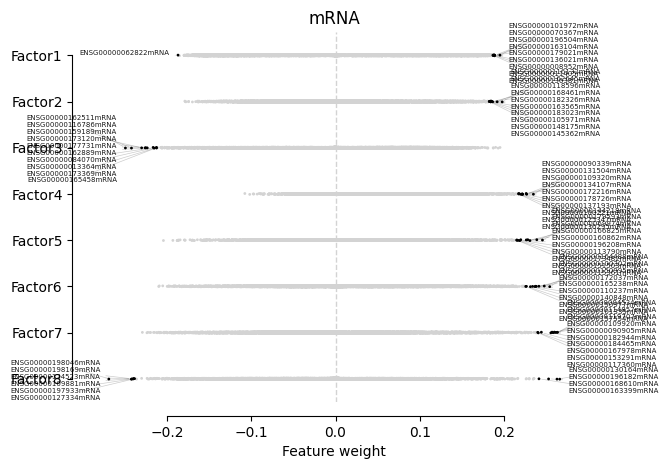

In [153]:
ax = mfx.plot_weights(m, n_features=10)

<Axes: >

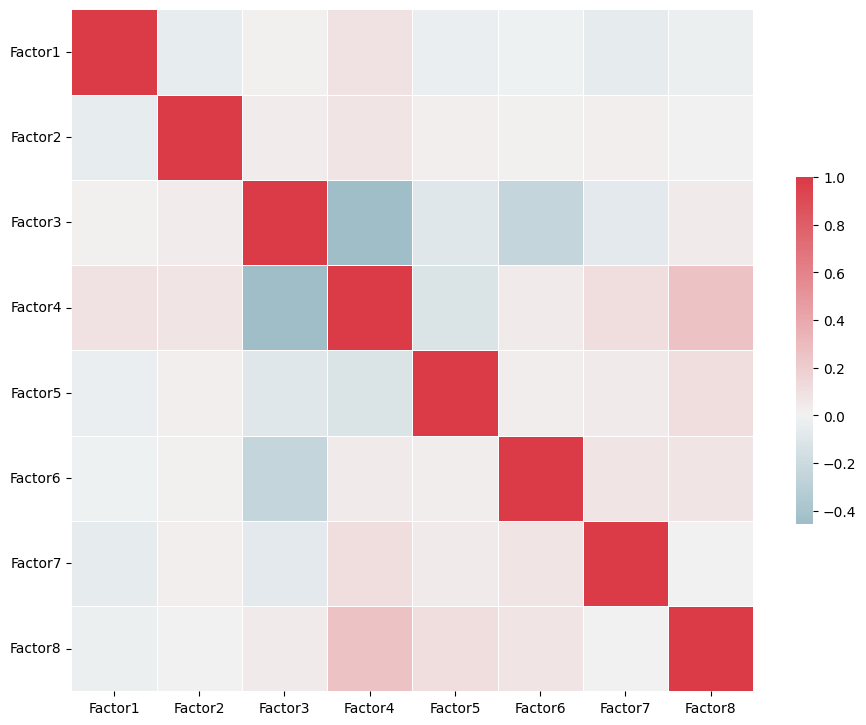

In [156]:
mfx.plot_weights_correlation(m)

In [158]:
m.get_r2(factors=list(range(9))).sort_values("R2", ascending=False)

,Factor,View,Group,R2
0,Factor1,mRNA,MSKCC_2010_Taylor,34.519809
0,Factor1,mRNA,CancerMap_2017_Luca,28.065665
0,Factor1,mRNA,CPC_GENE_2017_Fraser,26.610024
3,Factor4,mRNA,Atlanta_2014_Long,17.329594
0,Factor1,mRNA,DKFZ_2018_Gerhauser,11.828666
...,...,...,...,...
6,Factor7,mRNA,MSKCC_2010_Taylor,0.815966
7,Factor8,mRNA,Stockholm_2016_Ross_Adams,0.804737
6,Factor7,mRNA,Belfast_2018_Jain,0.484302
7,Factor8,mRNA,Belfast_2018_Jain,0.477088


## 2.3 VAE

In [49]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 100
X = intersection_exprs_df
X = torch.FloatTensor(X.values)
X_normalized = (X - X.min()) / (X.max() - X.min())
X_normalized = X_normalized.float()
X_tensor = TensorDataset(X_normalized)
dataloader = DataLoader(dataset=X_tensor, batch_size=batch_size, shuffle=True)

In [114]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=600, latent_dim=500, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
    
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def train(model, optimizer, epochs, device, x_dim):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x,) in enumerate(dataloader):
            #x = x.view(batch_size, x_dim).to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss


In [115]:
model = VAE(input_dim=len(intersection_exprs_df.columns)).to(device)
optimizer = Adam(model.parameters(), lr=0.001)     

In [116]:
train(model, optimizer, epochs=50, device=device, x_dim = len(intersection_exprs_df.columns))

	Epoch 1 	Average Loss:  10137.4546875
	Epoch 2 	Average Loss:  9948.8356875
	Epoch 3 	Average Loss:  9928.8610625
	Epoch 4 	Average Loss:  9917.2983125
	Epoch 5 	Average Loss:  9914.800875
	Epoch 6 	Average Loss:  9914.326375
	Epoch 7 	Average Loss:  9914.1386875
	Epoch 8 	Average Loss:  9914.139375
	Epoch 9 	Average Loss:  9914.077375
	Epoch 10 	Average Loss:  9914.02975
	Epoch 11 	Average Loss:  9914.057875
	Epoch 12 	Average Loss:  9914.034125
	Epoch 13 	Average Loss:  9914.02125
	Epoch 14 	Average Loss:  9914.0301875
	Epoch 15 	Average Loss:  9914.020625
	Epoch 16 	Average Loss:  9914.03875
	Epoch 17 	Average Loss:  9914.0424375
	Epoch 18 	Average Loss:  9914.021875
	Epoch 19 	Average Loss:  9914.04525
	Epoch 20 	Average Loss:  9914.0395625
	Epoch 21 	Average Loss:  9914.0386875
	Epoch 22 	Average Loss:  9914.047625
	Epoch 23 	Average Loss:  9914.040125
	Epoch 24 	Average Loss:  9914.048375
	Epoch 25 	Average Loss:  9914.0810625
	Epoch 26 	Average Loss:  9914.077125
	Epoch 27 	Ave

9908325.125